In [3]:
# Based on https://anilzen.github.io/post/2022/drawing-penrose-diagrams/
import numpy as np
import pandas as pd
from scipy.special import lambertw 
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

from scipy import signal

import os

plt.rcParams['font.family'] = 'serif'  # or 'DejaVu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 'DejaVu Serif' 'serif' 'Times
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'''
\usepackage{amsmath}
\usepackage{mathrsfs}
'''

In [4]:
M = 0.5

f = lambda r :1 - (2*M)/r 

In [5]:
# Array of constant values for t 
t_vals = np.linspace(-3.5, 3.5, 10)
# Tortoise coordinate on domain (-\infty, \infty)
r_tort = np.tan(np.pi/2*np.cos(np.pi * np.arange(0, 100+1) / 100))[::-1][2:-3]
# Schwarzschild-Droste radial coordinate r (the inverse of the tortoise coordinate)
r_schw = np.real(lambertw(np.exp(r_tort-1))+1)

In [6]:
def kruskal_coords(r, t, choice='t'):
    # https://en.wikipedia.org/wiki/Kruskal%E2%80%93Szekeres_coordinates#Definition
    # With G=1, M=1/2 (dimensionless coordinates)
    # r_tort = r + np.log(r-1); height = np.sqrt(1+r_tort**2) # hyperbolic in tortoise
    eps = 0.00001
    r = np.where(r == 1, 1 + eps, r)
    r = np.unique(r)
    
    r_tort = r + np.log(r-1);
    
    if choice == 'MG':
        height = r + 2*np.log(r) - np.log(r - 1) -2 # Macedo's Minimal Gaugue
    elif choice == 'PG':
        height = -2*np.sqrt(r) + np.log( (np.sqrt(r)+1)/(np.sqrt(r)-1)) # Gullstrand-Painleve
    elif choice == 'HT':
         height = np.sqrt(1+r_tort**2) # Zenginoğlu's Hyperbolic in Tortoise
    elif choice == 'IN':
        r_tort = r + np.log(r-1); height = - r_tort # Ingoing Eddington Finkelstein
    elif choice == 'OUT':
        r_tort = r + np.log(r-1); height = r_tort # Outgoing Eddington Finkelstein
    else:
        height = 0. # t Schwarzschild hypersurface
        
    rho = np.sqrt(r-1)*np.exp(r/2)*np.cosh((t+height)/2)
    # print(rho)
    tau = np.sqrt(r-1)*np.exp(r/2)*np.sinh((t+height)/2)
    R = 2./np.pi*(np.arctan(tau+rho)-np.arctan(tau-rho))
    T = 2./np.pi*(np.arctan(tau+rho)+np.arctan(tau-rho))
    
    # Create a boolean mask for elements to keep
    mask = ~((R == 1) & (T == 1))

    # Apply the mask to both arrays
    R_new = R[mask]
    T_new = T[mask]
    return R_new, T_new

In [7]:

def plotting(inputdirectory,outputdirectory,outputfilename='output'):
    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

    # colours
    dark_purple = (0.3, 0.0, 0.5)

    # Loop through all files in the directory
    directory=inputdirectory
    for filename in os.listdir(directory):
        # Check if the file is a CSV file
        if filename.endswith('.csv'):
            # Construct the full file path
            file_path = os.path.join(directory, filename)
            
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)
            
            # Plot the first column against the second column
            ax.plot(df.iloc[:, 0], df.iloc[:, 1], color=dark_purple, linewidth=0.75)

    # plot the singularities at r = 0
    # as a sawtooth-wave
    x0 = np.linspace(0, 0.98, 400)
    y0 = 1 + 0.04 * signal.sawtooth(14 * np.pi * 1 * x0, 0.5)
    ax.plot(x0, y0, color='red', zorder=6)

    x0 = np.linspace(0, 0.98, 400)
    y0 = -1 - 0.04 * signal.sawtooth(14 * np.pi * 1 * x0, 0.5)
    ax.plot(x0, y0, color='red', zorder=6)

    # bounding box
    x = [0, 1, 2, 1, 0]  # X coordinates
    y = [0, 1, 0, -1, 0]  # Y coordinates

    # Plotting and coloring the box
    ax.plot(x, y, color='black', zorder=7)
    ax.fill(x, y, color='C0', alpha=0.25, zorder=7)
    plt.gca().set_aspect('equal', adjustable='box')  
    # Set aspect ratio to make it look like a rhombus

    # Add labels
    plt.text(1, 1.05, r'$i^+$', fontsize=20)
    plt.plot(1, 1, 'o', markerfacecolor='white', markeredgecolor='black', alpha=1, zorder=10)

    plt.text(1, -1.18, r'$i^-$', fontsize=20)
    plt.plot(1, -1, 'o', markerfacecolor='white', markeredgecolor='black', alpha=1, zorder=10)

    plt.text(-0.18, -0.05, r'$\mathcal{B}$', fontsize=20)
    plt.plot(0, 0, 'o', markerfacecolor='black', markeredgecolor='black', alpha=1, zorder=10)

    plt.text(2.05, -0.05, r'$i^0$', fontsize=20)
    plt.plot(2, 0, 'o', markerfacecolor='black', markeredgecolor='black', alpha=1, zorder=10)

    plt.text(0.5 - 0.25, 0.5, r'$\mathcal{H}^+$', fontsize=20)
    plt.text(1.5 + 0.1, 0.5, r'$\mathscr{I}^+$', fontsize=20)

    plt.text(0.5 - 0.45, -0.5, r'$\mathcal{H}^-$', fontsize=20)
    plt.text(1.5 + 0.2, -0.5, r'$\mathscr{I}^-$', fontsize=20)
    
    plt.text(0.2, 1.1,r'$r=0$', color='red', fontsize=15)
    plt.text(0.2,-1.2,r'$r=0$', color='red', fontsize=15)

    # ax.grid(True)  # Add grid while editing

    # Final touches
    ax.set_xlim(-0.25, 2.25)
    ax.set_ylim(-1.25, 1.25)

    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth(1)  
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    plt.savefig(outputdirectory+outputfilename+'.pdf', dpi=300, bbox_inches="tight")


In [8]:
# set a directory to save the figures

OUTPUTDIR = 'figs/'
if not os.path.exists(OUTPUTDIR):
    os.makedirs(OUTPUTDIR)

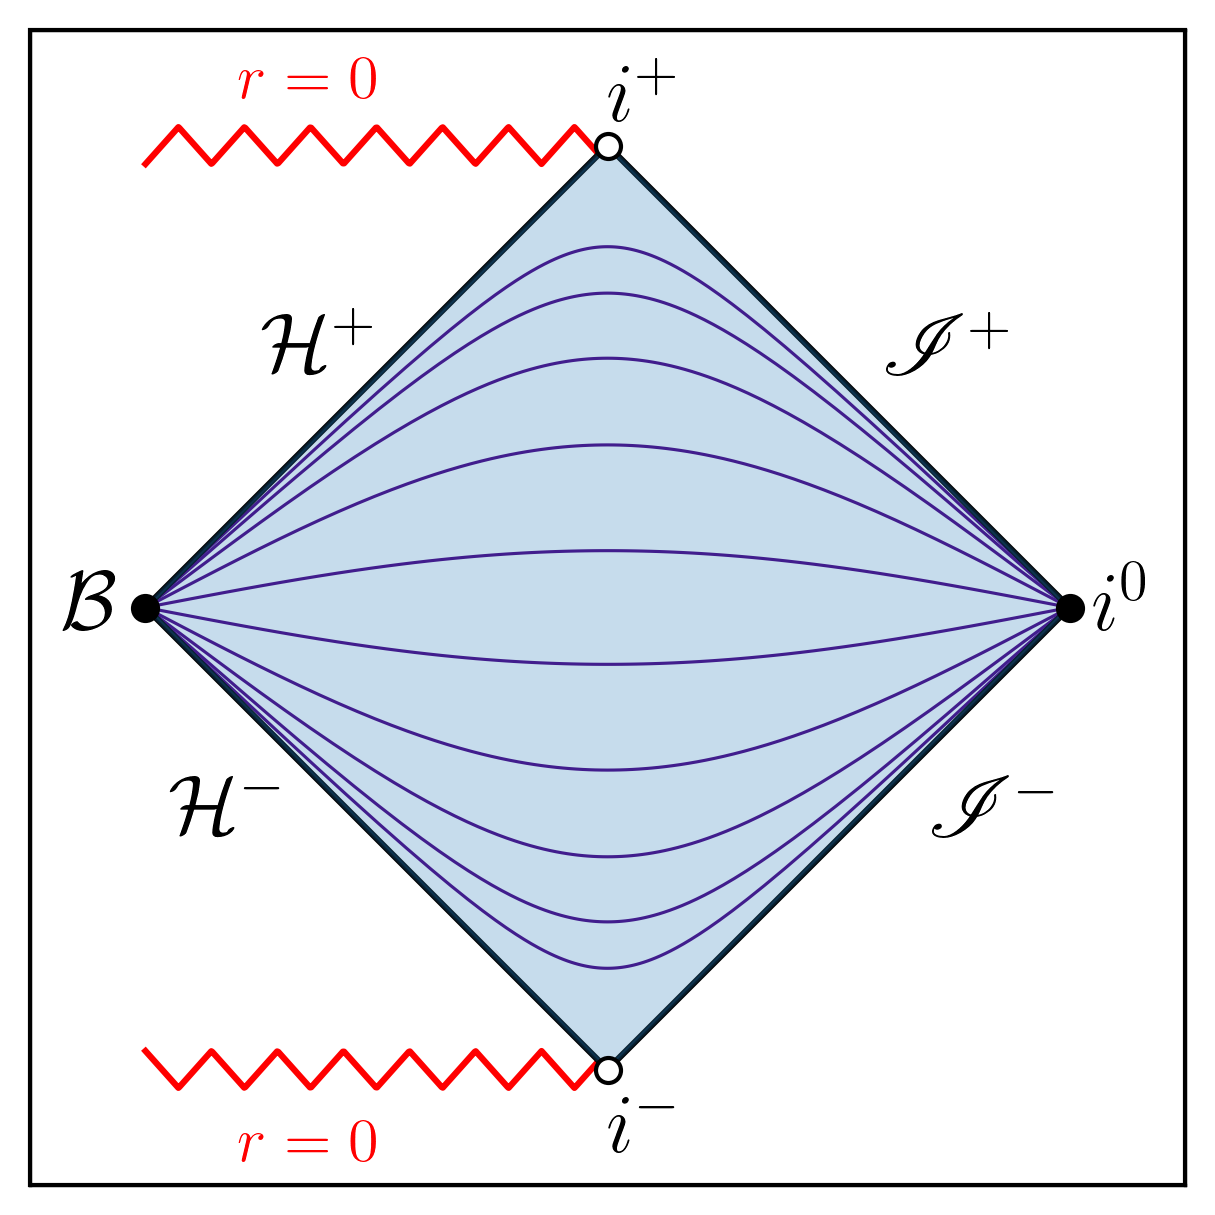

In [9]:
# t constant foliation

PATH='data/t/'
if not os.path.exists(PATH):
    os.makedirs(PATH)
    
for i, t_val in enumerate(t_vals):
    R, T = kruskal_coords(r_schw, t_val)
    fn = PATH+str(i)+'.csv'
    np.savetxt(fn, np.stack((R, T)).T,
               delimiter=',', fmt='%f', header="R,T", comments="")
plotting(PATH,OUTPUTDIR,'schwarzschild_t_const')

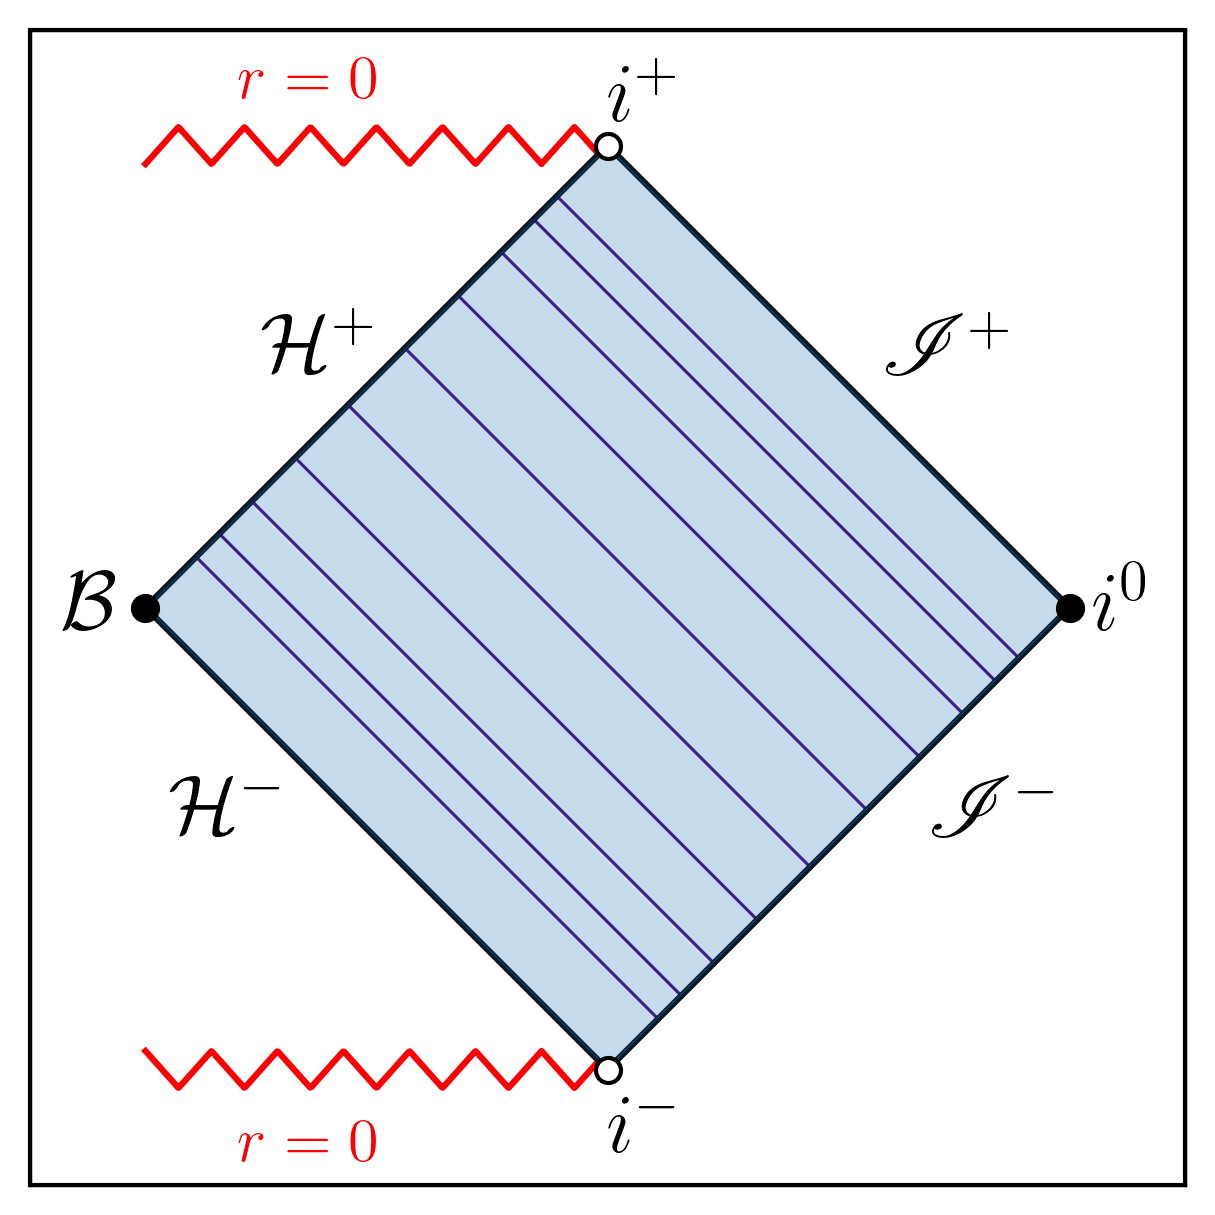

In [10]:
# v constant foliation

PATH='data/v/'
if not os.path.exists(PATH):
    os.makedirs(PATH)

foliation = 'IN'
for i, t_val in enumerate(t_vals):
    R, T = kruskal_coords(r_schw, t_val, foliation)
    fn = PATH+str(i)+'.csv'
    np.savetxt(fn, np.stack((R, T)).T,
               delimiter=',', fmt='%f', header="R,T", comments="")
plotting(PATH,OUTPUTDIR,'schwarzschild_v_const')

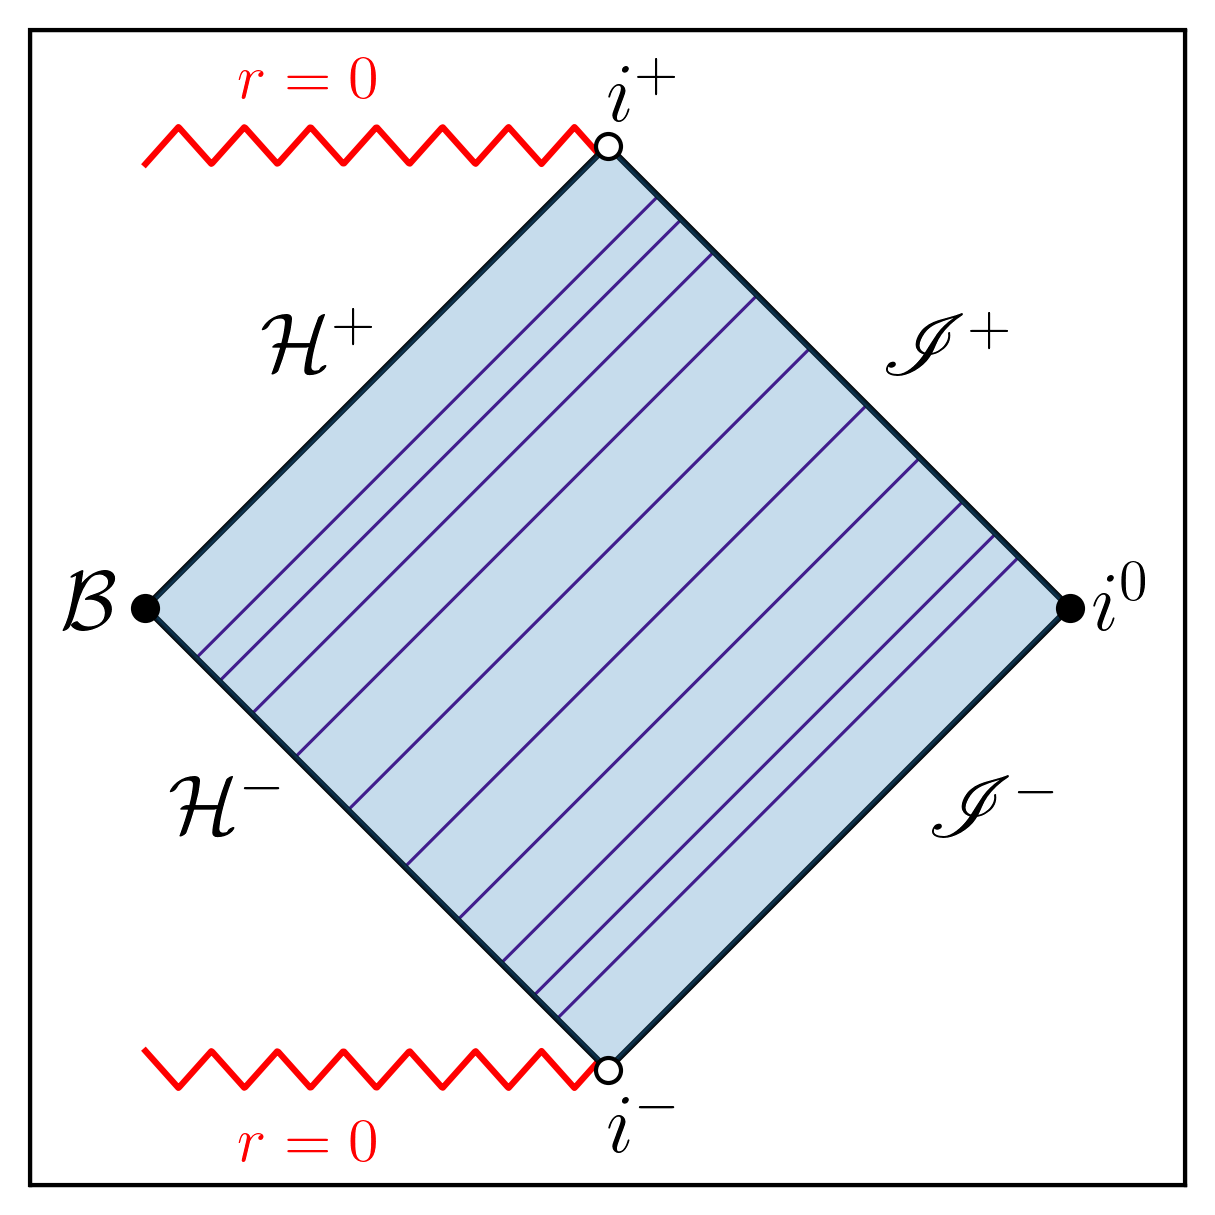

In [11]:
# u constant foliation

PATH='data/u/'
if not os.path.exists(PATH):
    os.makedirs(PATH)

foliation = 'OUT'
for i, t_val in enumerate(t_vals):
    R, T = kruskal_coords(r_schw, t_val, foliation)
    fn = PATH+str(i)+'.csv'
    np.savetxt(fn, np.stack((R, T)).T,
               delimiter=',', fmt='%f', header="R,T", comments="")
plotting(PATH,OUTPUTDIR,'schwarzschild_u_const')

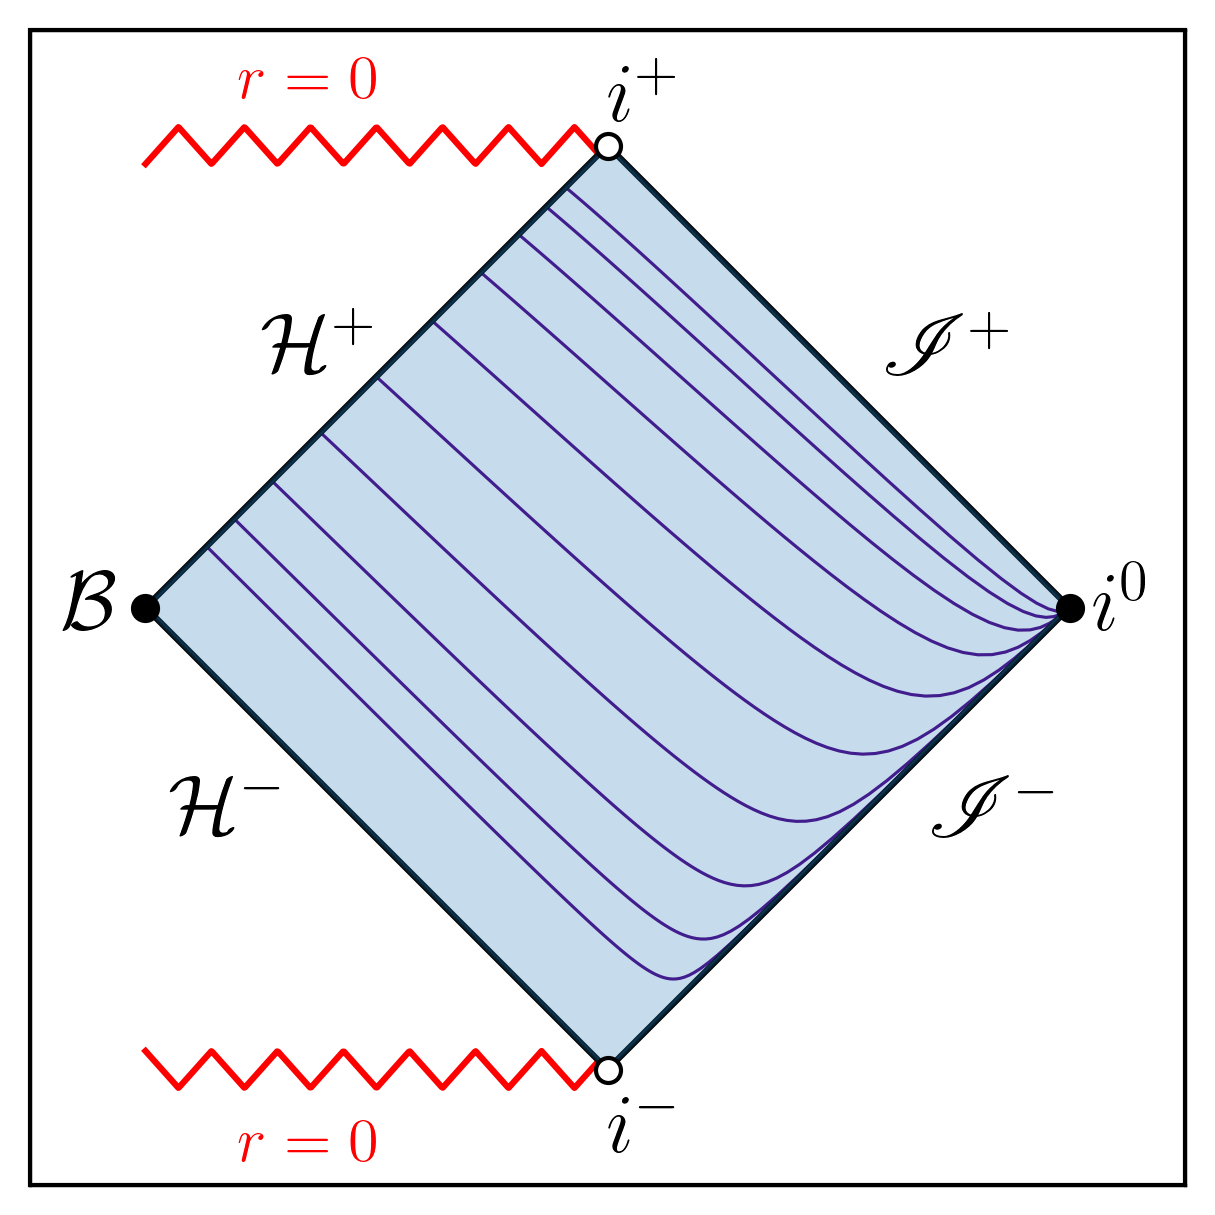

In [12]:
# pg  foliation

PATH='data/pg/'
if not os.path.exists(PATH):
    os.makedirs(PATH)

foliation = 'PG'
for i, t_val in enumerate(t_vals):
    R, T = kruskal_coords(r_schw, t_val, foliation)
    fn = PATH+str(i)+'.csv'
    np.savetxt(fn, np.stack((R, T)).T,
               delimiter=',', fmt='%f', header="R,T", comments="")
plotting(PATH,OUTPUTDIR,'schwarzschild_pg')

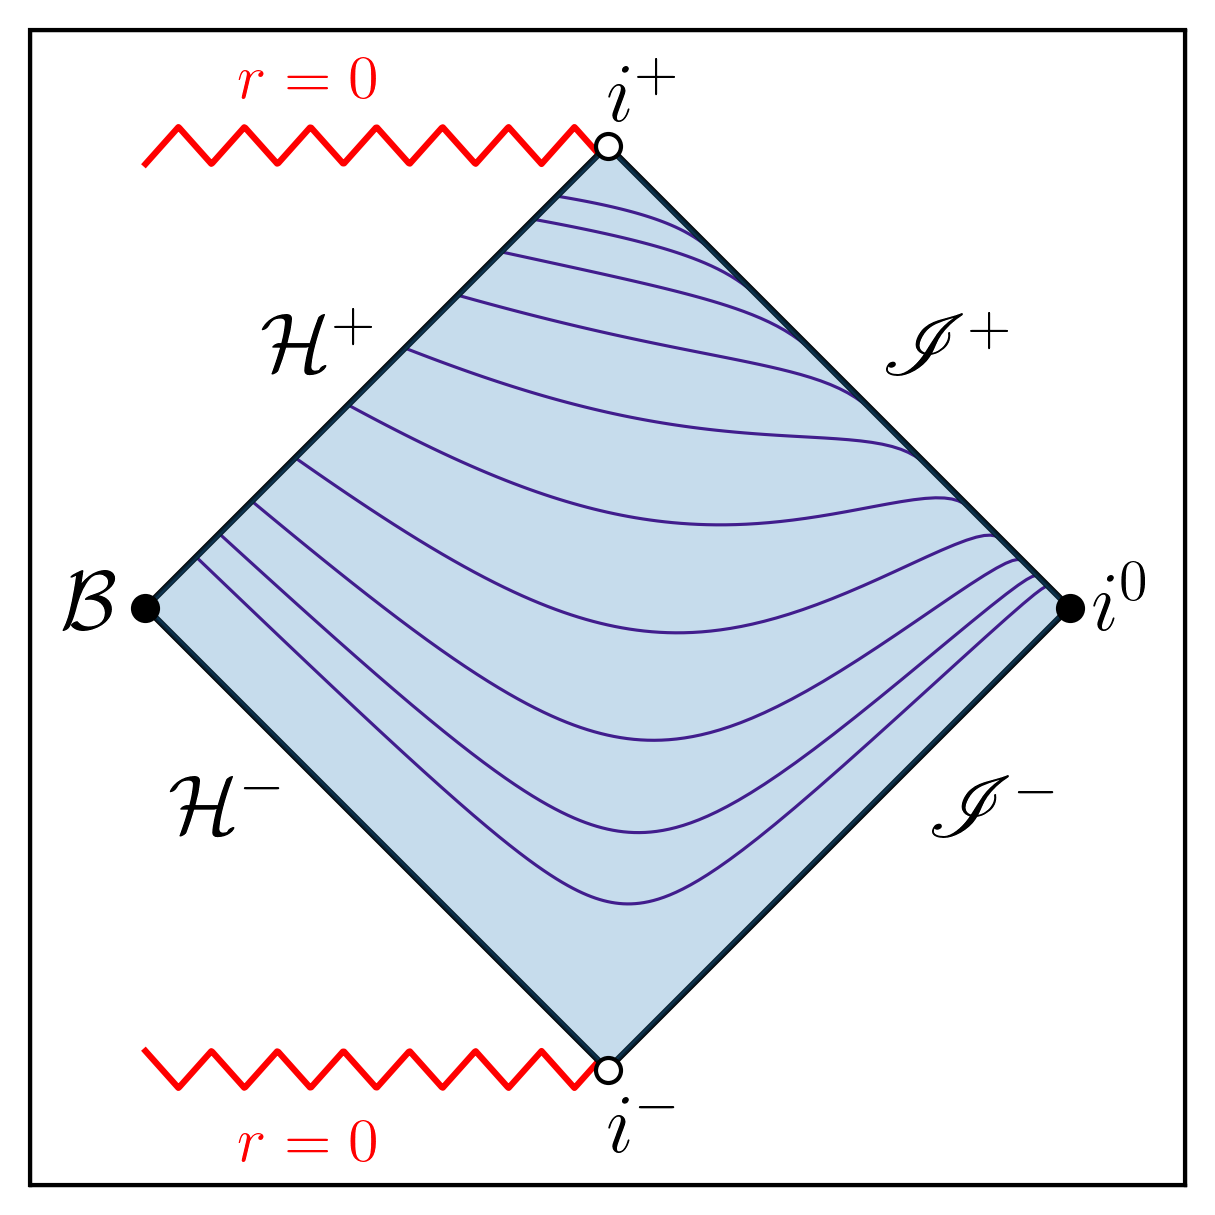

In [13]:
# \tau constant foliation
# minimal gauge

PATH='data/tauMG/'
if not os.path.exists(PATH):
    os.makedirs(PATH)

foliation = 'MG'
for i, t_val in enumerate(t_vals):
    R, T = kruskal_coords(r_schw, t_val, foliation)
    fn = PATH+str(i)+'.csv'
    np.savetxt(fn, np.stack((R, T)).T,
               delimiter=',', fmt='%f', header="R,T", comments="")
plotting(PATH,OUTPUTDIR,'schwarzschild_tauMG_const')

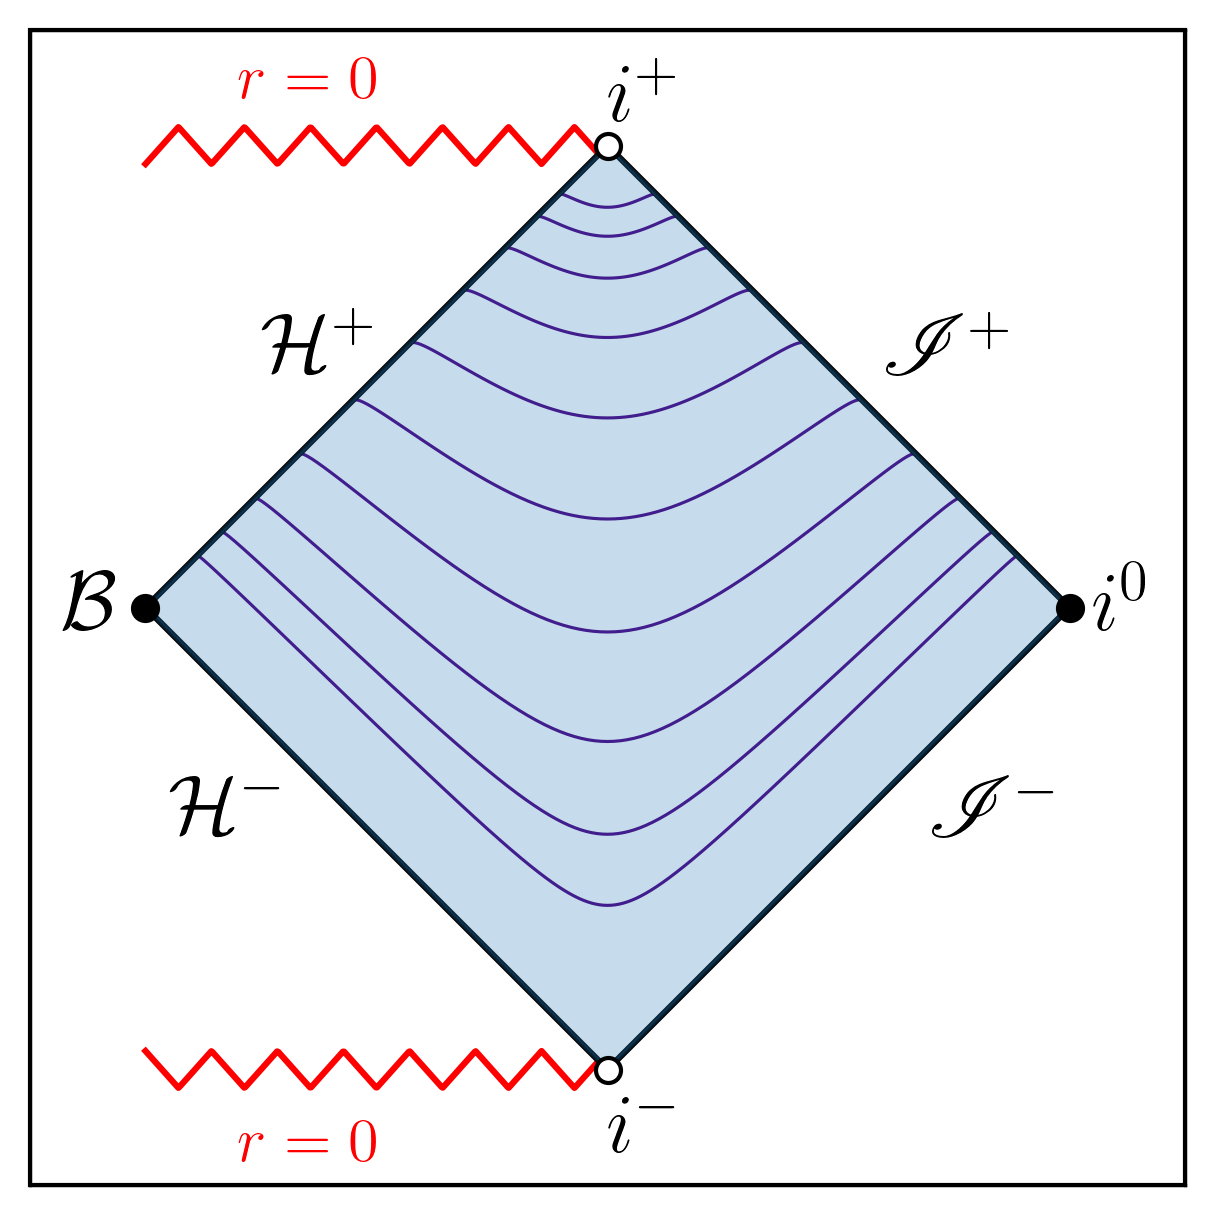

In [14]:
# \tau constant foliation
# HYPERBOLIC TORTOISE

PATH='data/tauHT/'
if not os.path.exists(PATH):
    os.makedirs(PATH)

foliation = 'HT'
for i, t_val in enumerate(t_vals):
    R, T = kruskal_coords(r_schw, t_val, foliation)
    fn = PATH+str(i)+'.csv'
    np.savetxt(fn, np.stack((R, T)).T,
               delimiter=',', fmt='%f', header="R,T", comments="")
plotting(PATH,OUTPUTDIR,'schwarzschild_tauHT_const')

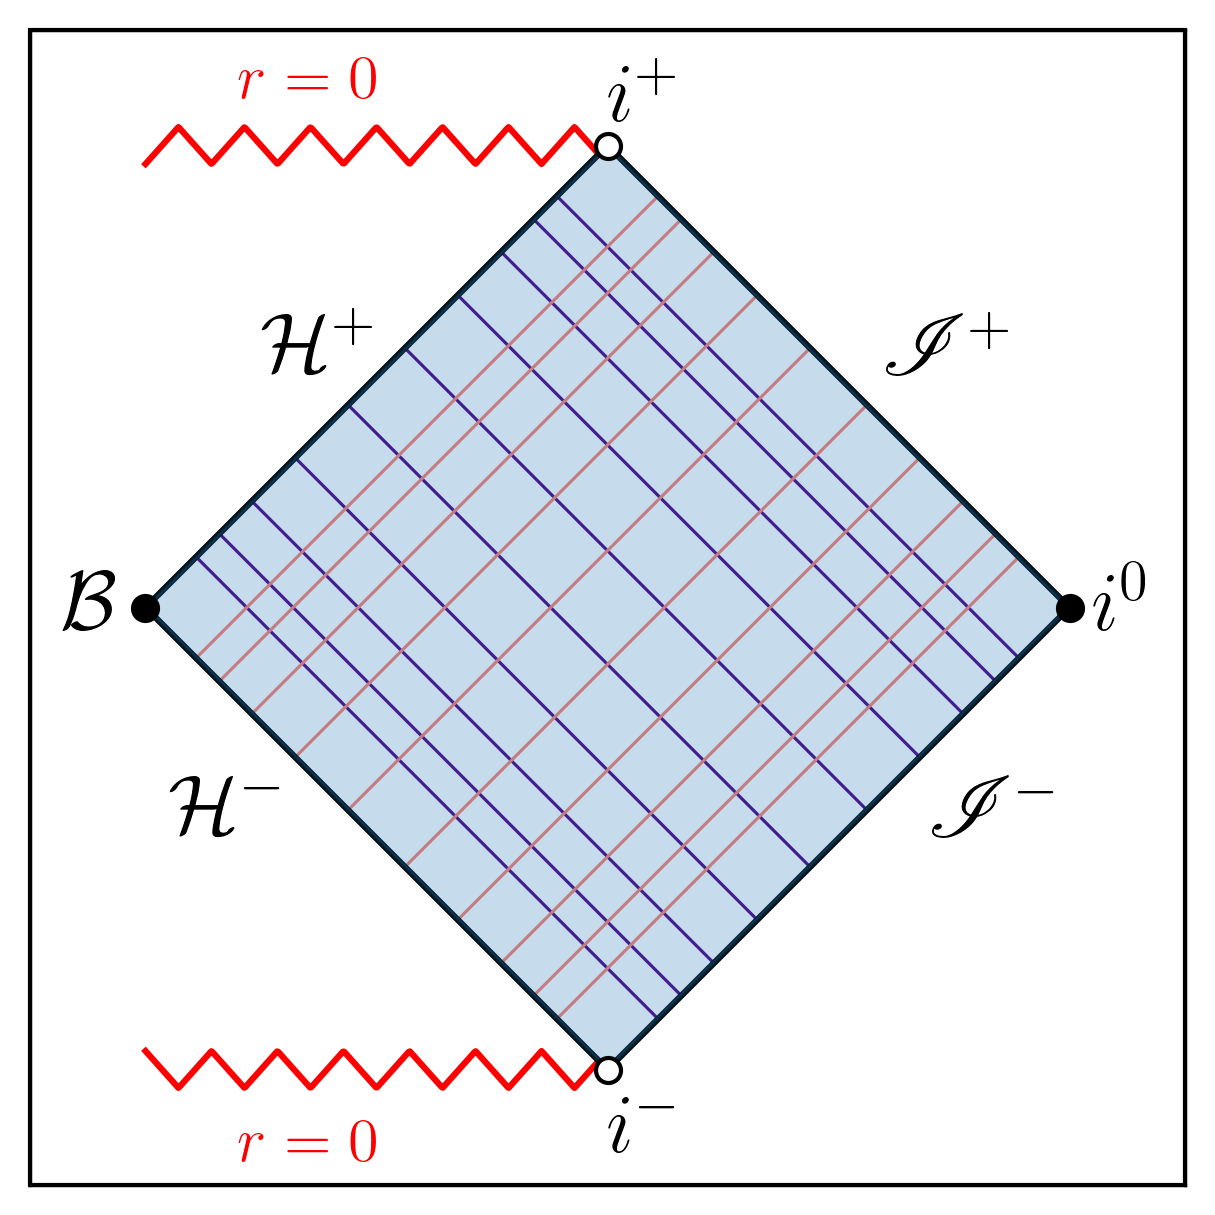

In [15]:
## plot U V  const hyper surfaces

fig, ax = plt.subplots(figsize=(5, 5),dpi=300)

#colours
dark_purple = (0.3, 0.0, 0.5)
dark_orange = (0.8, 0.4, 0.0)

# Loop through all files in the directory
directory='data/v/'
for filename in os.listdir(directory):
    # Check if the file is a CSV file
    if filename.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Plot the first column against the second column
        ax.plot(df.iloc[:, 0], df.iloc[:, 1], color=dark_purple, linewidth=0.75)

# Loop through all files in the directory
directory='data/u/'
for filename in os.listdir(directory):
    # Check if the file is a CSV file
    if filename.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Plot the first column against the second column
        ax.plot(df.iloc[:, 0], df.iloc[:, 1], color='salmon', linewidth=0.75)
        
# plot the singularities at r = 0
# as a sawtooth-wave
x0 = np.linspace(0, 0.98, 400)
y0 = 1+0.04* signal.sawtooth(14 * np.pi * 1 * x0,0.5)
ax.plot(x0, y0, color='red',zorder=6)

x0 = np.linspace(0, 0.98, 400)
y0 = - 1-0.04* signal.sawtooth(14 * np.pi * 1 *x0,0.5)
ax.plot(x0, y0, color='red',zorder=6)

# bounding box
x = [0, 1, 2,  1,  0]  # X coordinates
y = [0, 1, 0, -1,  0]  # Y coordinates

# Plotting and coloring the box
ax.plot(x, y,color='black',zorder=7)
ax.fill(x,y,color='C0', alpha=0.25,zorder=7)
plt.gca().set_aspect('equal', adjustable='box')  
# Set aspect ratio to make it look like a rhombus

# Add labels
plt.text(1,1.05,r'$i^+$',fontsize=20)
plt.plot(1,1,'o',markerfacecolor='white',markeredgecolor='black',alpha=1,zorder=10) 

plt.text(1,-1.18,r'$i^-$',fontsize=20)
plt.plot(1,-1,'o',markerfacecolor='white',markeredgecolor='black',alpha=1,zorder=10) 

plt.text(-0.18,-.05,r'$\mathcal{B}$',fontsize=20)
plt.plot(0,0,'o',markerfacecolor='black',markeredgecolor='black',alpha=1,zorder=10) 

plt.text(2.05,-.05,r'$i^0$',fontsize=20)
plt.plot(2,0,'o',markerfacecolor='black',markeredgecolor='black',alpha=1,zorder=10) 

plt.text(0.5-0.25,0.5,r'$\mathcal{H}^+$',fontsize=20)
plt.text(1.5+0.1,0.5, r'$\mathscr{I}^+$',fontsize=20)

plt.text(0.5-0.45,-0.5,r'$\mathcal{H}^-$',fontsize=20)
plt.text(1.5+0.2,-0.5, r'$\mathscr{I}^-$',fontsize=20)

plt.text(0.2, 1.1,r'$r=0$', color='red', fontsize=15)
plt.text(0.2,-1.2,r'$r=0$', color='red', fontsize=15)

# ax.grid(True)  # Add grid while editing

# Final touches
ax.set_xlim(-0.25,2.25)
ax.set_ylim(-1.25,1.25)

ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth(1)  
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

plt.savefig(OUTPUTDIR+'schwarzschild_NULL_constant.pdf', dpi=300,bbox_inches="tight")


In [16]:
# Original code due to Zenginoğlu
#  M = 1/2, horizon is at r=1
# import numpy as np
# from scipy.special import lambertw      # For the tortoise coordinate

# def kruskal_coords(r, t):
#     # https://en.wikipedia.org/wiki/Kruskal%E2%80%93Szekeres_coordinates#Definition
#     # With G=1, M=1/2 (dimensionless coordinates)
#     height = -2*np.sqrt(r) + np.log( (np.sqrt(r)+1)/(np.sqrt(r)-1) ) # Gullstrand-Painleve
#     # r_tort = r + np.log(r-1); height = np.sqrt(1+r_tort**2) # hyperbolic in tortoise
#     #height = r + 2*np.log(r) - np.log(r - 1) - 2 # minimal gauge
#     #height = 0.
#     rho = np.sqrt(r-1)*np.exp(r/2)*np.cosh((t+height)/(2))
#     tau = np.sqrt(r-1)*np.exp(r/2)*np.sinh((t+height)/(2))
#     R = 2./np.pi*(np.arctan(tau+rho)-np.arctan(tau-rho))
#     T = 2./np.pi*(np.arctan(tau+rho)+np.arctan(tau-rho))
#     return R, T

# # Array of constant values for t 
# t_vals = np.linspace(-3., 3, 10)
# # Tortoise coordinate on domain (-\infty, \infty)
# r_tort = np.tan(np.pi/2*np.cos(np.pi * np.arange(0, 100+1) / 100))[::-1][2:-1]
# # Schwarzschild-Droste radial coordinate r (the inverse of the tortoise coordinate)
# r_schw = np.real(lambertw(np.exp(r_tort-1))+1)

# for i, t_val in enumerate(t_vals):
#     R, T = kruskal_coords(r_schw, t_val)
#     fn = 'data/ss'+str(i)+'.csv'
#     np.savetxt(fn, np.stack((R, T)).T,
#                delimiter=',', fmt='%f', header="R,T", comments="")
#     print('{'+fn+'},')

